https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python

In [1]:
!pip3 install transformers numpy torch sklearn

     |████████████████████████████████| 2.3MB 11.0MB/s 
     |████████████████████████████████| 901kB 34.5MB/s 
     |████████████████████████████████| 3.3MB 28.7MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import plot_confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download([
     "names",
     "stopwords",
     "vader_lexicon",
     "punkt",
 ])
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import seaborn as sns
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
train_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/train.tsv'
val_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/valid.tsv'
test_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/test.tsv'

train = pd.read_csv(train_url, delimiter='\t', header=None)
val = pd.read_csv(val_url, delimiter='\t', header=None)
test = pd.read_csv(test_url, delimiter='\t', header=None)
rename_columns = ['ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title', 'state_info',
                  'party_affiliation', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                  'context'
                 ]
train.columns = rename_columns
val.columns = rename_columns
test.columns = rename_columns
all_data = pd.concat([train, val, test])

In [4]:
drop_columns = ['ID']
train.drop(drop_columns, axis=1, inplace = True)
train['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
train['state_info'].fillna('none', inplace=True) # temporary until I find better way
train['context'].fillna('', inplace = True)
train.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
train.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
train.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
train = train.reset_index(drop=True)

val.drop(drop_columns, axis=1, inplace = True)
val['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
val['state_info'].fillna('none', inplace=True) # temporary until I find better way
val['context'].fillna('', inplace = True)
val.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
val.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
val.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
val = val.reset_index(drop=True)

test.drop(drop_columns, axis=1, inplace = True)
test['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
test['state_info'].fillna('none', inplace=True) # temporary until I find better way
test['context'].fillna('', inplace = True)
test.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
test.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
test.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
test = test.reset_index(drop=True)

In [5]:
def pre_process_text(text):
  text = text.lower()
  text_p = "".join([char for char in text if char not in string.punctuation])

  words = word_tokenize(text_p)

  stop_words = stopwords.words('english')
  filtered_words = [word for word in words if word not in stop_words]

  # porter = PorterStemmer()
  # stemmed = [porter.stem(word) for word in filtered_words]
  
  # pos = pos_tag(filtered_words)
  
  return ' '.join(filtered_words)

In [6]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

In [7]:
set_seed(1)

In [8]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [9]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

Attempt 1 - Binary Classification

In [10]:
label_map = {'false': 'false', 'half-true': 'false', 'mostly-true': 'true', 'true': 'true', 'barely-true': 'false', 'pants-fire': 'false'}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = pd.concat([X_train, X_val], ignore_index=True)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
y_train = y_train.astype('category').cat.codes
X_train.drop(['label'], axis=1, inplace=True)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop = True)
y_train = y_train.reset_index(drop=True)
y_train = y_train.astype('int64')
y_val = y_val.reset_index(drop = True)
y_val = y_val.astype('int64')


X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
y_test = y_test.astype('category').cat.codes
X_test.drop(['label'], axis=1, inplace=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
X_train.head()

In [ ]:
X_val.head()

In [ ]:
y_train.head()

In [ ]:
list(X_train['statement'])

In [11]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(list(X_train['statement']), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(list(X_val['statement']), truncation=True, padding=True, max_length=max_length)

In [12]:
class LiarDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = LiarDataset(train_encodings, y_train)
valid_dataset = LiarDataset(valid_encodings, y_val)

In [13]:
target_names = ['false', 'true']
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [15]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [16]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [17]:
# train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.636200,0.630499,0.649395
400,0.633100,0.641052,0.644398
600,0.619700,0.639119,0.633351
800,0.583600,0.670494,0.653603
1000,0.567400,0.708360,0.656497
1200,0.363300,0.800165,0.639926
1400,0.334000,0.838664,0.638611


TrainOutput(global_step=1449, training_loss=0.5265938388305833, metrics={'train_runtime': 2143.6758, 'train_samples_per_second': 0.676, 'total_flos': 45759839852880.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 16384, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -439496704, 'train_mem_gpu_alloc_delta': 1329040384, 'train_mem_cpu_peaked_delta': 454074368, 'train_mem_gpu_peaked_delta': 1174614528})

In [18]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.6493950552340874,
 'eval_loss': 0.6304986476898193,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 674064896,
 'eval_runtime': 170.6253,
 'eval_samples_per_second': 22.283}

In [19]:
# saving the fine tuned model & tokenizer
model_path = "liar-bert-base-uncased_binary_1"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('liar-bert-base-uncased_binary_1/tokenizer_config.json',
 'liar-bert-base-uncased_binary_1/special_tokens_map.json',
 'liar-bert-base-uncased_binary_1/vocab.txt',
 'liar-bert-base-uncased_binary_1/added_tokens.json',
 'liar-bert-base-uncased_binary_1/tokenizer.json')

In [20]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]

In [21]:
test_pred = [get_prediction(text) for text in np.array(X_test['statement'])]

In [ ]:
test_pred

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import seaborn as sns

In [24]:
test_pred = [0 if x == 'false' else 1 for x in test_pred]

In [25]:
test_acc_score = accuracy_score(y_test, test_pred)
print(f'Test accuracy: {test_acc_score}')

Test accuracy: 0.6563981042654028


In [26]:
mat = confusion_matrix(y_test, test_pred)

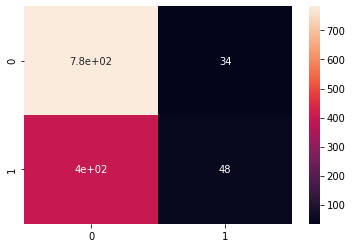

In [27]:
sns.heatmap(mat, annot=True)

Attempt 2 - BERT multi classification

In [ ]:
label_map = {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
y_train = y_train.astype('int64')
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
y_val = y_val.astype('int64')
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
y_test = y_test.astype('int64')
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
X_val

In [ ]:
y_val

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(list(X_train['statement']), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(list(X_val['statement']), truncation=True, padding=True, max_length=max_length)

In [ ]:
class LiarDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = LiarDataset(train_encodings, y_train)
valid_dataset = LiarDataset(valid_encodings, y_val)

In [ ]:
label_map = {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}
target_names = ['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=500,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
X_train

,label,statement,subjects,speaker,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...
10231,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10232,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,republican,0.0,0.0,0.0,1.0,0.0,an interview
10233,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10234,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [ ]:
# train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
500,1.751400,1.731216,0.241433,6.566900,195.525000
1000,1.658300,1.701279,0.267913,6.543900,196.215000
1500,1.485000,1.879648,0.254673,6.531500,196.585000


TrainOutput(global_step=1920, training_loss=1.5376404603322347, metrics={'train_runtime': 2258.3107, 'train_samples_per_second': 0.85, 'total_flos': 7282356929160912.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -114688, 'train_mem_gpu_alloc_delta': 1757996032, 'train_mem_cpu_peaked_delta': 11231232, 'train_mem_gpu_peaked_delta': 7128893952})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.26791277258566976,
 'eval_loss': 1.7012791633605957,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 71054336,
 'eval_runtime': 6.2867,
 'eval_samples_per_second': 204.241}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "liar-bert-base-uncased_multi_2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('liar-bert-base-uncased_multi_2/tokenizer_config.json',
 'liar-bert-base-uncased_multi_2/special_tokens_map.json',
 'liar-bert-base-uncased_multi_2/vocab.txt',
 'liar-bert-base-uncased_multi_2/added_tokens.json')

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]

In [ ]:
test_pred_2 = [get_prediction(text) for text in np.array(X_test['statement'])]

In [ ]:
test_pred_2 = [label_map[x] for x in test_pred_2]
# test_pred = [0 if x == 'false' else 1 for x in test_pred]

Test accuracy: 0.27488151658767773


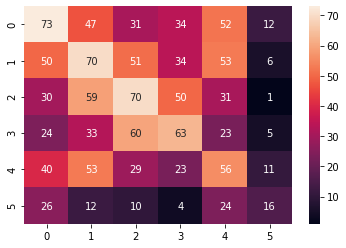

In [ ]:
test_acc_score = accuracy_score(y_test, test_pred_2)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, test_pred_2)
sns.heatmap(mat, annot=True)

Attempt 3 - load Attempt 2 

In [ ]:
label_map = {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
y_train = y_train.astype('int64')
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
y_val = y_val.astype('int64')
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
y_test = y_test.astype('int64')
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(list(X_train['statement']), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(list(X_val['statement']), truncation=True, padding=True, max_length=max_length)

In [ ]:
class LiarDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = LiarDataset(train_encodings, y_train)
valid_dataset = LiarDataset(valid_encodings, y_val)

In [ ]:
label_map = {'false': 0, 'half-true': 1, 'mostly-true': 2, 'true': 3, 'barely-true': 4, 'pants-fire': 5}
target_names = ['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained('bert2', local_files_only=True, num_labels=len(target_names)).to("cuda")